In [89]:
!nvidia-smi

Mon Sep  9 00:05:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   49C    P8             24W /  170W |    1428MiB /  12288MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [102]:
import torch
import torchvision
import  torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image

In [103]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),                # Resize the image to 28x28 pixels  
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize R, G, B channels
])

In [104]:
training_set = torchvision.datasets.CIFAR100(
    './data',
    train=True,
    transform=transform,
    download=True
)
validation_set = torchvision.datasets.CIFAR100(

    './data',
    train=False,
    transform=transform,
    download=True
)


Files already downloaded and verified
Files already downloaded and verified


In [105]:
image, label =  training_set[4]
print(image.shape)
print(label)
print(len(training_set.classes))

torch.Size([3, 64, 64])
1
100


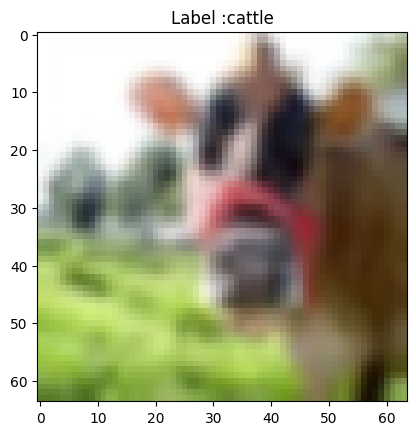

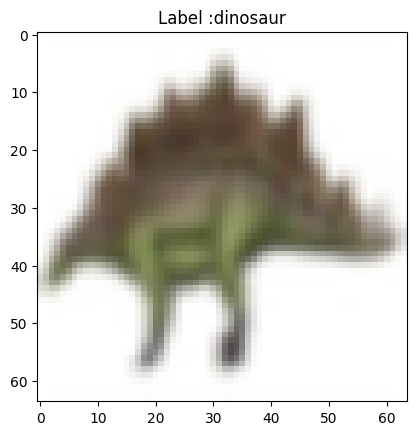

In [106]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(2):
    image , label = training_set[i]
    image = image / 2 + 0.5
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(training_set.classes[label]))
    plt.show()

In [107]:
def compute_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [108]:
device = compute_device()
device

device(type='cuda')

In [109]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [110]:
class DeviceDataLoader():
    def __init__(self,data_loader,device) -> None:
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self):
        for batch in self.data_loader:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data_loader)

In [111]:
import torch.utils


training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=4096,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4096,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
train_loader = DeviceDataLoader(training_loader,device)
val_loader = DeviceDataLoader(validation_loader,device)

Target:  tensor([74, 89, 15, 35, 41,  4, 20, 34,  1, 73, 23, 56, 56, 88, 19, 56, 48, 24,
         3, 45, 82, 16, 71, 11, 61, 54, 27, 33, 61, 49, 85, 38, 51, 58, 33, 14,
        31, 13, 61, 17, 72, 35, 27,  6, 31, 83, 86, 36, 78, 79, 91,  1, 14, 91,
        20, 75, 45, 12, 93, 76, 15,  2, 33, 64, 90, 21, 84,  9, 19, 18, 99, 36,
        71, 25, 66, 55, 73,  9, 95, 23, 69, 83, 96, 65, 33, 53, 16, 54, 13, 49,
        33, 34, 19, 76, 64, 87, 51, 53,  0, 70])


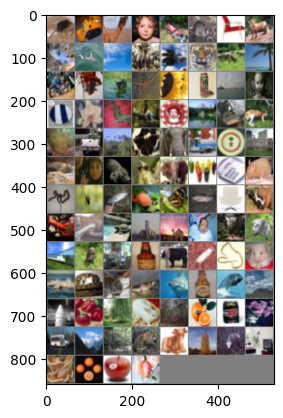

In [112]:

def show_image(img: torch.Tensor):
  img = img / 2 + 0.5
  plt.imshow(img.permute(1,2,0))

dataiter = iter(training_loader)
num_images_to_display = 100
images, labels = next(dataiter)
if images.size(0) > num_images_to_display:
    images = images[:num_images_to_display]
    labels = labels[:num_images_to_display]
img_grid = torchvision.utils.make_grid(images)


show_image(img_grid)
print("Target: ", labels)

In [114]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.first_layer = nn.Linear(
        12288, 
        4096 
    )
    self.first_activation = nn.ReLU() # activation relu

   
    self.second_layer = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU()
    )

    self.output = nn.Sequential(
        nn.Linear(512, 100),
        nn.Softmax(dim=-1)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.first_layer(x)
    x = self.first_activation(x)
    x = self.second_layer(x)
    x = self.output(x)
    return x

In [115]:
x = torch.randn(1, 3, 64, 64)
net = Net()
net.eval()
with torch.no_grad():
    probs = net(x)

In [116]:
print(probs)
print(probs.sum())

tensor([[0.0093, 0.0098, 0.0103, 0.0106, 0.0104, 0.0101, 0.0102, 0.0093, 0.0098,
         0.0097, 0.0100, 0.0096, 0.0094, 0.0107, 0.0111, 0.0088, 0.0091, 0.0116,
         0.0090, 0.0104, 0.0096, 0.0089, 0.0115, 0.0094, 0.0104, 0.0092, 0.0093,
         0.0102, 0.0105, 0.0103, 0.0112, 0.0096, 0.0098, 0.0092, 0.0094, 0.0087,
         0.0096, 0.0102, 0.0088, 0.0107, 0.0101, 0.0126, 0.0096, 0.0103, 0.0097,
         0.0093, 0.0088, 0.0119, 0.0120, 0.0075, 0.0101, 0.0098, 0.0104, 0.0099,
         0.0110, 0.0108, 0.0094, 0.0098, 0.0083, 0.0084, 0.0098, 0.0084, 0.0100,
         0.0089, 0.0103, 0.0100, 0.0098, 0.0096, 0.0090, 0.0100, 0.0116, 0.0099,
         0.0109, 0.0104, 0.0117, 0.0092, 0.0098, 0.0116, 0.0086, 0.0105, 0.0107,
         0.0105, 0.0110, 0.0097, 0.0099, 0.0082, 0.0083, 0.0102, 0.0104, 0.0128,
         0.0101, 0.0097, 0.0103, 0.0097, 0.0105, 0.0109, 0.0100, 0.0098, 0.0121,
         0.0099]])
tensor(1.)


In [117]:
net = to_device(Net(), device)

In [118]:
net = Net()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [119]:
from tqdm import tqdm
def train_one_epoch(epoch):
    total_loss = 0
    train_tqdm = tqdm(enumerate(training_loader), total=len(training_loader))

    for i, data in train_tqdm:
        inputs, labels = data

        outputs = net(inputs)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        train_tqdm.set_description(f"Epoch {epoch}: Total loss: {total_loss/(i + 1)}")

    return total_loss / len(training_loader)

In [122]:
num_epochs = 250
best_acc = 0

for epoch in range(1, num_epochs + 1, 1):

    net.train(True)
    train_loss = train_one_epoch(epoch)

    preds = []
    gts = []

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            inputs, labels = data
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=-1)
            gts += labels.tolist()
            preds += outputs.tolist()

    # tính acc
    acc = torch.sum(
        torch.tensor(gts) == torch.tensor(preds)
    )/len(gts)

    print(f"Epoch {epoch}: Val acc = {acc}")

    if acc >= best_acc:
        best_acc = acc
        model_path = 'model_{}_{}'.format(epoch, acc)
        torch.save(net.state_dict(), model_path) # lưu mô hình

Epoch 1: Total loss: 4.498389610877404: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 1: Val acc = 0.11999999731779099


Epoch 2: Total loss: 4.489095724545992: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 2: Val acc = 0.1234000027179718


Epoch 3: Total loss: 4.4825119238633375: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


Epoch 3: Val acc = 0.13050000369548798


Epoch 4: Total loss: 4.476052284240723: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 4: Val acc = 0.13680000603199005


Epoch 5: Total loss: 4.466083013094389: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it] 


Epoch 5: Val acc = 0.14180000126361847


Epoch 6: Total loss: 4.458995305574858: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 6: Val acc = 0.14550000429153442


Epoch 7: Total loss: 4.453762751359206: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 7: Val acc = 0.15049999952316284


Epoch 8: Total loss: 4.447522970346304: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 8: Val acc = 0.15379999577999115


Epoch 9: Total loss: 4.442384426410381: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 9: Val acc = 0.15629999339580536


Epoch 10: Total loss: 4.43794349523691: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it] 


Epoch 10: Val acc = 0.15790000557899475


Epoch 11: Total loss: 4.4320083398085375: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 11: Val acc = 0.16179999709129333


Epoch 12: Total loss: 4.428454985985389: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 12: Val acc = 0.15950000286102295


Epoch 13: Total loss: 4.425257719480074: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 13: Val acc = 0.16339999437332153


Epoch 14: Total loss: 4.420566082000732: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 14: Val acc = 0.1664000004529953


Epoch 15: Total loss: 4.416147452134353: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 15: Val acc = 0.16920000314712524


Epoch 16: Total loss: 4.414194547213041: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 16: Val acc = 0.17059999704360962


Epoch 17: Total loss: 4.409111939943754: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 17: Val acc = 0.1720000058412552


Epoch 18: Total loss: 4.4049440163832445: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 18: Val acc = 0.17270000278949738


Epoch 19: Total loss: 4.402468938093919: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 19: Val acc = 0.17329999804496765


Epoch 20: Total loss: 4.399345141190749: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 20: Val acc = 0.17509999871253967


Epoch 21: Total loss: 4.394192035381611: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 21: Val acc = 0.17430000007152557


Epoch 22: Total loss: 4.3925472773038425: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 22: Val acc = 0.17759999632835388


Epoch 23: Total loss: 4.391253361335168: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 23: Val acc = 0.17800000309944153


Epoch 24: Total loss: 4.38887280684251: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 24: Val acc = 0.17759999632835388


Epoch 25: Total loss: 4.3826170701247: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]  


Epoch 25: Val acc = 0.18019999563694


Epoch 26: Total loss: 4.380800870748667: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 26: Val acc = 0.17970000207424164


Epoch 27: Total loss: 4.377171259659987: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 27: Val acc = 0.18160000443458557


Epoch 28: Total loss: 4.374557018280029: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 28: Val acc = 0.18250000476837158


Epoch 29: Total loss: 4.3714064084566555: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 29: Val acc = 0.18240000307559967


Epoch 30: Total loss: 4.369443306556115: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 30: Val acc = 0.18389999866485596


Epoch 31: Total loss: 4.367292587573711: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 31: Val acc = 0.18649999797344208


Epoch 32: Total loss: 4.363692577068623: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 32: Val acc = 0.18649999797344208


Epoch 33: Total loss: 4.3616288625277: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]   


Epoch 33: Val acc = 0.1858000010251999


Epoch 34: Total loss: 4.3585614791283245: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 34: Val acc = 0.18559999763965607


Epoch 35: Total loss: 4.3585896492004395: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 35: Val acc = 0.18770000338554382


Epoch 36: Total loss: 4.354509940514197: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 36: Val acc = 0.18610000610351562


Epoch 37: Total loss: 4.352380972642165: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 37: Val acc = 0.18809999525547028


Epoch 38: Total loss: 4.350049128899207: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 38: Val acc = 0.1881999969482422


Epoch 39: Total loss: 4.349094941065862: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 39: Val acc = 0.1882999986410141


Epoch 40: Total loss: 4.347743694598858: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 40: Val acc = 0.1873999983072281


Epoch 41: Total loss: 4.345223573537973: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 41: Val acc = 0.1882999986410141


Epoch 42: Total loss: 4.342491773458628: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 42: Val acc = 0.1891999989748001


Epoch 43: Total loss: 4.341136125417856: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 43: Val acc = 0.19110000133514404


Epoch 44: Total loss: 4.336404103499192: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 44: Val acc = 0.1907999962568283


Epoch 45: Total loss: 4.33682628778311: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]  


Epoch 45: Val acc = 0.19189999997615814


Epoch 46: Total loss: 4.337635040283203: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 46: Val acc = 0.19020000100135803


Epoch 47: Total loss: 4.335707077613244: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 47: Val acc = 0.19089999794960022


Epoch 48: Total loss: 4.334704179030198: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 48: Val acc = 0.19269999861717224


Epoch 49: Total loss: 4.331318635206956: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 49: Val acc = 0.19210000336170197


Epoch 50: Total loss: 4.330112127157358: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it] 


Epoch 50: Val acc = 0.19050000607967377


Epoch 51: Total loss: 4.328669548034668: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 51: Val acc = 0.19140000641345978


Epoch 52: Total loss: 4.328305171086238: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 52: Val acc = 0.19359999895095825


Epoch 53: Total loss: 4.32724666595459: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 53: Val acc = 0.1932000070810318


Epoch 54: Total loss: 4.324705564058744: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 54: Val acc = 0.1914999932050705


Epoch 55: Total loss: 4.32504521883451: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 55: Val acc = 0.19339999556541443


Epoch 56: Total loss: 4.3219248698307915: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 56: Val acc = 0.19460000097751617


Epoch 57: Total loss: 4.320572706369253: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 57: Val acc = 0.1931000053882599


Epoch 58: Total loss: 4.3183064093956585: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 58: Val acc = 0.19419999420642853


Epoch 59: Total loss: 4.317508477431077: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 59: Val acc = 0.1949000060558319


Epoch 60: Total loss: 4.316277173849253: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it] 


Epoch 60: Val acc = 0.19539999961853027


Epoch 61: Total loss: 4.316898235907922: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 61: Val acc = 0.19460000097751617


Epoch 62: Total loss: 4.31724474980281: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 62: Val acc = 0.19539999961853027


Epoch 63: Total loss: 4.315664621499868: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


Epoch 63: Val acc = 0.19339999556541443


Epoch 64: Total loss: 4.312112404749944: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]


Epoch 64: Val acc = 0.19470000267028809


Epoch 65: Total loss: 4.311553881718562: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 65: Val acc = 0.19709999859333038


Epoch 66: Total loss: 4.310962823721079: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 66: Val acc = 0.19619999825954437


Epoch 67: Total loss: 4.3086951695955715: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 67: Val acc = 0.19740000367164612


Epoch 68: Total loss: 4.309916569636418: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 68: Val acc = 0.19529999792575836


Epoch 69: Total loss: 4.307629255148081: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it] 


Epoch 69: Val acc = 0.19509999454021454


Epoch 70: Total loss: 4.305235349214994: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 70: Val acc = 0.19589999318122864


Epoch 71: Total loss: 4.30516635454618: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 71: Val acc = 0.19629999995231628


Epoch 72: Total loss: 4.3072925347548265: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 72: Val acc = 0.1972000002861023


Epoch 73: Total loss: 4.302933216094971: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 73: Val acc = 0.19480000436306


Epoch 74: Total loss: 4.303402423858643: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 74: Val acc = 0.19660000503063202


Epoch 75: Total loss: 4.302061521089994: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 75: Val acc = 0.1956000030040741


Epoch 76: Total loss: 4.301714713756855: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 76: Val acc = 0.1941000074148178


Epoch 77: Total loss: 4.300407666426438: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 77: Val acc = 0.19599999487400055


Epoch 78: Total loss: 4.29801684159499: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 78: Val acc = 0.1972000002861023


Epoch 79: Total loss: 4.296565055847168: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 79: Val acc = 0.19740000367164612


Epoch 80: Total loss: 4.296708767230694: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 80: Val acc = 0.19679999351501465


Epoch 81: Total loss: 4.296158607189472: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 81: Val acc = 0.19740000367164612


Epoch 82: Total loss: 4.294366139632005: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 82: Val acc = 0.19599999487400055


Epoch 83: Total loss: 4.293980525090144: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


Epoch 83: Val acc = 0.19470000267028809


Epoch 84: Total loss: 4.2937110020564155: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 84: Val acc = 0.19820000231266022


Epoch 85: Total loss: 4.292430584247295: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 85: Val acc = 0.20000000298023224


Epoch 86: Total loss: 4.291099548339844: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 86: Val acc = 0.19859999418258667


Epoch 87: Total loss: 4.291392142956074: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 87: Val acc = 0.19740000367164612


Epoch 88: Total loss: 4.289455487177922: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 88: Val acc = 0.19750000536441803


Epoch 89: Total loss: 4.289823312025804: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it] 


Epoch 89: Val acc = 0.1972000002861023


Epoch 90: Total loss: 4.284989320314848: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 90: Val acc = 0.20010000467300415


Epoch 91: Total loss: 4.288157206315261: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 91: Val acc = 0.1988999992609024


Epoch 92: Total loss: 4.286538674281194: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 92: Val acc = 0.2004999965429306


Epoch 93: Total loss: 4.284192231985239: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 93: Val acc = 0.19939999282360077


Epoch 94: Total loss: 4.285335797529954: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 94: Val acc = 0.1988999992609024


Epoch 95: Total loss: 4.283391402317927: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 95: Val acc = 0.1996999979019165


Epoch 96: Total loss: 4.283681245950552: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 96: Val acc = 0.2013999968767166


Epoch 97: Total loss: 4.281298013833853: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 97: Val acc = 0.20100000500679016


Epoch 98: Total loss: 4.281631212968093: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 98: Val acc = 0.2011999934911728


Epoch 99: Total loss: 4.278789850381704: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 99: Val acc = 0.2020999938249588


Epoch 100: Total loss: 4.2811785111060505: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 100: Val acc = 0.2029000073671341


Epoch 101: Total loss: 4.278367409339318: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 101: Val acc = 0.20100000500679016


Epoch 102: Total loss: 4.278161562406099: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 102: Val acc = 0.20280000567436218


Epoch 103: Total loss: 4.277984399061936: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 103: Val acc = 0.20160000026226044


Epoch 104: Total loss: 4.278424483079177: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 104: Val acc = 0.20149999856948853


Epoch 105: Total loss: 4.276154664846567: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 105: Val acc = 0.20160000026226044


Epoch 106: Total loss: 4.275494685539832: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 106: Val acc = 0.20229999721050262


Epoch 107: Total loss: 4.2749313574570875: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 107: Val acc = 0.20250000059604645


Epoch 108: Total loss: 4.275637700007512: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 108: Val acc = 0.2012999951839447


Epoch 109: Total loss: 4.27463593849769: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]  


Epoch 109: Val acc = 0.2004999965429306


Epoch 110: Total loss: 4.273055406717154: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 110: Val acc = 0.20100000500679016


Epoch 111: Total loss: 4.274779649881216: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 111: Val acc = 0.20190000534057617


Epoch 112: Total loss: 4.271833786597619: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 112: Val acc = 0.2020999938249588


Epoch 113: Total loss: 4.272449383368859: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 113: Val acc = 0.2020999938249588


Epoch 114: Total loss: 4.27335603420551: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 114: Val acc = 0.20280000567436218


Epoch 115: Total loss: 4.270103307870718: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 115: Val acc = 0.20280000567436218


Epoch 116: Total loss: 4.26837447973398: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 116: Val acc = 0.2021999955177307


Epoch 117: Total loss: 4.267908793229323: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 117: Val acc = 0.20389999449253082


Epoch 118: Total loss: 4.2674815104557915: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 118: Val acc = 0.20389999449253082


Epoch 119: Total loss: 4.269041208120493: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it] 


Epoch 119: Val acc = 0.20160000026226044


Epoch 120: Total loss: 4.267804072453425: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 120: Val acc = 0.2020999938249588


Epoch 121: Total loss: 4.265862428225004: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it] 


Epoch 121: Val acc = 0.20409999787807465


Epoch 122: Total loss: 4.267293783334585: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 122: Val acc = 0.20399999618530273


Epoch 123: Total loss: 4.265639378474309: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


Epoch 123: Val acc = 0.2029000073671341


Epoch 124: Total loss: 4.265180230140686:  31%|███       | 4/13 [00:06<00:15,  1.67s/it] 


KeyboardInterrupt: 